In [ ]:
!pip install tensorflow numpy imageio
import os
import zipfile
import random
import cv2
import numpy as np
import keras.layers as KL
import keras.models as KM
import tensorflow as tf
import keras
import multiprocessing
import datetime
import imageio
import matplotlib.pyplot as plt

from keras.losses import mean_squared_error
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import layers, models as KM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from keras.models import load_model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#ZIP AND EXTRACT
# directories for zip file

zip_path = "/content/BSD500.zip"

# Extract the contents of the zip file
extracted_path = '/content/BSD500'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

#don't forget -> import data, create folder name calls "BSD500"

In [ ]:
# preprocessing - resizing

all_path = "/content/BSD500/images"
new_width = 1120
new_height = 1120

#iterate for each folder
for folder in os.listdir(all_path):
    folder_path = os.path.join(all_path, folder)
    if os.path.isdir(folder_path):
      datasetType = os.path.basename(folder)
      preprocessing_path = "/content/preprocessing_images/" + datasetType
      source_path = "/content/BSD500/images/" + datasetType

        # Iterate for each image
      for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
          continue

        # resize
        resized = cv2.resize(image, (new_width, new_height))
        # Save resized image
        cv2.imwrite(os.path.join(preprocessing_path, image_file), resized)
        cv2.imwrite(os.path.join(source_path, image_file), resized)
#don't forget -> create preprocessing_images folder, with the inside folder such as: test, train, val

In [ ]:
# preprocessing - filtering - white gaussian noise

kernel_size = 5
sigma = 2
preprocessing_path = "/content/preprocessing_images"

for folder in os.listdir(preprocessing_path):
    folder_path = os.path.join(preprocessing_path, folder)
    if os.path.isdir(folder_path):

        # Iterate for each image
      for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # blurring
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

        # Save gaussian blur image
        cv2.imwrite(os.path.join(folder_path, image_file), blurred)

In [ ]:
def unet(kernel, layer):
    filters = 64
    model_inp = layers.Input(shape=(layer, layer, 3))

    # Encoder
    c1 = layers.Conv2D(filters, kernel, name="c1", use_bias=True, padding='same')(model_inp)
    c1 = layers.LeakyReLU(alpha=0.2)(c1)
    c1a = layers.Conv2D(filters, kernel, name="c1a", use_bias=True, padding='same')(c1)
    c1a = layers.LeakyReLU(alpha=0.2)(c1a)
    p1 = layers.MaxPooling2D(pool_size=2, name="max-pooling_1")(c1a)

    c2 = layers.Conv2D(filters * 2, kernel, name="c2", use_bias=True, padding='same')(p1)
    c2 = layers.LeakyReLU(alpha=0.2)(c2)
    c2a = layers.Conv2D(filters * 2, kernel, name="c2a", use_bias=True, padding='same')(c2)
    c2a = layers.LeakyReLU(alpha=0.2)(c2a)
    p2 = layers.MaxPooling2D(pool_size=2, name="max-pooling_2")(c2a)

    c3 = layers.Conv2D(filters * 4, kernel, name="c3", use_bias=True, padding='same')(p2)
    c3 = layers.LeakyReLU(alpha=0.2)(c3)
    c3a = layers.Conv2D(filters * 4, kernel, name="c3a", use_bias=True, padding='same')(c3)
    c3a = layers.LeakyReLU(alpha=0.2)(c3a)
    p3 = layers.MaxPooling2D(pool_size=2, name="max-pooling_3")(c3a)

    c4 = layers.Conv2D(filters * 8, kernel, name="c4", use_bias=True, padding='same')(p3)
    c4 = layers.LeakyReLU(alpha=0.2)(c4)
    c4a = layers.Conv2D(filters * 8, kernel, name="c4a", use_bias=True, padding='same')(c4)
    c4a = layers.LeakyReLU(alpha=0.2)(c4a)
    p4 = layers.MaxPooling2D(pool_size=2, name="max-pooling_4")(c4a)

    c5 = layers.Conv2D(filters * 16, kernel, name="c5", use_bias=True, padding='same')(p4)
    c5 = layers.LeakyReLU(alpha=0.2)(c5)

    # Decoder
    up4 = layers.UpSampling2D(size=2)(c5)
    up4 = layers.Conv2D(filters * 8, kernel, name="up-convolution_4", use_bias=True, padding='same')(up4)
    up4 = layers.Concatenate()([up4, c4a])  # Adjusted shape here

    d4 = layers.Conv2D(filters * 8, kernel, name="d4", use_bias=True, padding='same')(up4)
    d4 = layers.LeakyReLU(alpha=0.2)(d4)
    d4 = layers.Conv2D(filters * 8, kernel, name="d4a", use_bias=True, padding='same')(d4)
    d4 = layers.LeakyReLU(alpha=0.2)(d4)

    up3 = layers.UpSampling2D(size=2)(d4)
    up3 = layers.Conv2D(filters * 4, kernel, name="up-convolution_3", use_bias=True, padding='same')(up3)
    up3 = layers.Concatenate()([up3, c3a])  # Adjusted shape here

    d3 = layers.Conv2D(filters * 4, kernel, name="d3", use_bias=True, padding='same')(up3)
    d3 = layers.LeakyReLU(alpha=0.2)(d3)
    d3 = layers.Conv2D(filters * 4, kernel, name="d3a", use_bias=True, padding='same')(d3)
    d3 = layers.LeakyReLU(alpha=0.2)(d3)

    up2 = layers.UpSampling2D(size=2)(d3)
    up2 = layers.Conv2D(filters * 2, kernel, name="up-convolution_2", use_bias=True, padding='same')(up2)
    up2 = layers.Concatenate()([up2, c2a])  # Adjusted shape here

    d2 = layers.Conv2D(filters * 2, kernel, name="d2", use_bias=True, padding='same')(up2)
    d2 = layers.LeakyReLU(alpha=0.2)(d2)
    d2 = layers.Conv2D(filters * 2, kernel, name="d2a", use_bias=True, padding='same')(d2)
    d2 = layers.LeakyReLU(alpha=0.2)(d2)

    up1 = layers.UpSampling2D(size=2)(d2)
    up1 = layers.Conv2D(filters, kernel, name="up-convolution_1", use_bias=True, padding='same')(up1)
    up1 = layers.Concatenate()([up1, c1a])  # Adjusted shape here

    d1 = layers.Conv2D(filters, kernel, name="d1", use_bias=True, padding='same')(up1)
    d1 = layers.LeakyReLU(alpha=0.2)(d1)
    d1 = layers.Conv2D(filters, kernel, name="d1a", use_bias=True, padding='same')(d1)
    d1 = layers.LeakyReLU(alpha=0.2)(d1)

    model_out = layers.Conv2D(3, kernel, activation="tanh", padding='same')(d1)

    model = KM.Model(model_inp, model_out)

    return model

In [ ]:
kernel = 2
layer = 256

In [ ]:
model = unet(kernel, layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 c1 (Conv2D)                    (None, 256, 256, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['c1[0][0]']                     
                                )                                                             

In [ ]:
class ImageDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, target_size, shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_files = sorted(os.listdir(image_dir))
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_files_batch = [self.image_files[i] for i in indexes]

        # Initialize batch arrays
        X = np.empty((self.batch_size,) + self.target_size + (3,), dtype=np.float32)
        y = np.empty((self.batch_size,) + self.target_size + (3,), dtype=np.float32)

        # Load and preprocess images
        for i, image_file in enumerate(image_files_batch):
            image_path = os.path.join(self.image_dir, image_file)

            # Load noisy image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size)  # Resize image
            image = image.astype(np.float32) / 255.0

            # Load clean image
            clean_image_file = image_file.replace("noisy", "clean")
            clean_image_path = os.path.join(self.image_dir, clean_image_file)
            clean_image = cv2.imread(clean_image_path)
            clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB)
            clean_image = cv2.resize(clean_image, self.target_size)  # Resize image
            clean_image = clean_image.astype(np.float32) / 255.0

            X[i] = image
            y[i] = clean_image

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
# Set up directories and parameters

train_dir = "/content/preprocessing_images/train"
val_dir = "/content/preprocessing_images/val"
image_size = (layer,layer)
batch_size = 8

# Create data generators
train_generator = ImageDataGenerator(train_dir, batch_size, image_size)
val_generator = ImageDataGenerator(val_dir, batch_size, image_size)

# Create the model
model = unet(kernel, layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error', metrics=['mae'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 685s 27s/step - loss: 0.1949 - mae: 0.3777 - val_loss: 0.1615 - val_mae: 0.3383
Epoch 2/10
25/25 [==============================] - 684s 28s/step - loss: 0.1112 - mae: 0.2655 - val_loss: 0.0707 - val_mae: 0.2127
Epoch 3/10
25/25 [==============================] - 683s 27s/step - loss: 0.0577 - mae: 0.1867 - val_loss: 0.0500 - val_mae: 0.1744
Epoch 4/10
25/25 [==============================] - 679s 27s/step - loss: 0.0480 - mae: 0.1691 - val_loss: 0.0441 - val_mae: 0.1613
Epoch 5/10
25/25 [==============================] - 683s 27s/step - loss: 0.0419 - mae: 0.1572 - val_loss: 0.0390 - val_mae: 0.1492
Epoch 6/10
25/25 [==============================] - 680s 27s/step - loss: 0.0372 - mae: 0.1466 - val_loss: 0.0347 - val_mae: 0.1403
Epoch 7/10
25/25 [==============================] - 679s 27s/step - loss: 0.0338 - mae: 0.1387 - val_loss: 0.0319 - val_mae: 0.1335
Epoch 8/10
25/25 [==============================] - 678s 27s/step - loss: 0.

Last MAE: 0.12384510040283203
Last Validation MAE: 0.11981425434350967


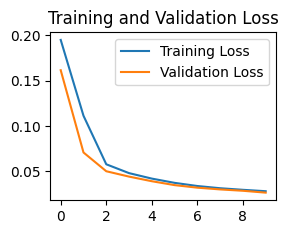

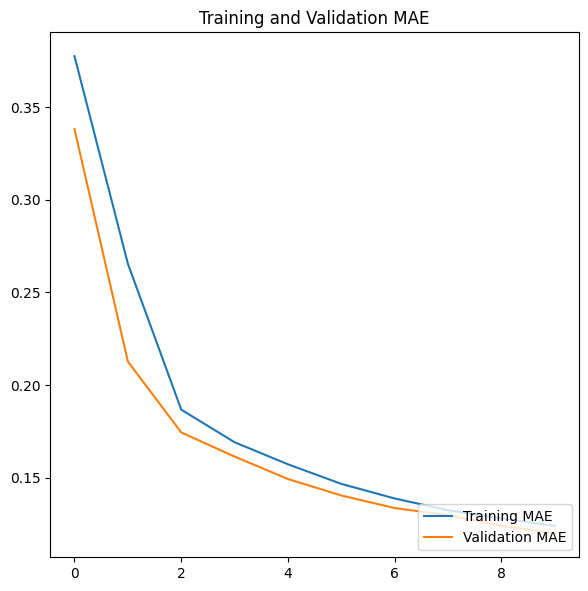

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
last_mae = mae[-1]  # Last MAE value
last_val_mae = val_mae[-1]  # Last validation MAE value

epochs_range = range(10)

print("Last MAE:", last_mae)
print("Last Validation MAE:", last_val_mae)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.show()